In [59]:
import torchvision.datasets as datasets
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pathlib import Path


In [3]:
from sklearn.decomposition import PCA
import numpy as np


def prep_mnist(mnist_set, n_components):
    # should we normalize the data?
    filtered_mnist_set = []
    for image in mnist_set:
        if image[1] == 0 or image[1] == 1:
            filtered_mnist_set.append(image)

    X = [np.asarray(val[0]).flatten() for val in filtered_mnist_set]
    Y = [val[1] for val in filtered_mnist_set]

    pca = PCA(n_components=n_components)
    X_PC = pca.fit_transform(X)
    return (X_PC, Y)

def confusion_matrix(Y, Y_hat):
    # Y is the ground truth
    # Y_hat is the predicted labels
    # returns the confusion matrix
    cm = np.zeros((2, 2))
    for i in range(len(Y)):
        cm[Y[i], Y_hat[i]] += 1
    return cm


In [84]:
class KNNClassifier:
    def __init__(self, X, Y):
        self.X_clf = np.array(X)
        self.Y_clf = np.array(Y)

    def classify(self, x, k, dist_func=np.linalg.norm, decision_weighted=False):
        # Implement the k-NN classifier
        # x is a single vector to classify
        # k is the number of neighbors to consider
        # returns the most common class among the k nearest neighbors
        if self.X_clf is None or self.Y_clf is None:
            raise Exception("Classifier not trained")

        # Vectorized implementation for speed
        distances = dist_func(self.X_clf - x, axis=1)
        sorted_indices = np.argsort(distances)
        k_nearest_indices = sorted_indices[:k]
        k_nearest_labels = self.Y_clf[k_nearest_indices]
        # count the number of 0s and 1s
        count0 = 0
        count1 = 0
        if decision_weighted:
            for i in range(len(k_nearest_indices)):
                if k_nearest_labels[i] == 0:
                    count0 += 1 / distances[k_nearest_indices[i]]
                else:
                    count1 += 1 / distances[k_nearest_indices[i]]
        else:
            for i in range(len(k_nearest_indices)):
                if k_nearest_labels[i] == 0:
                    count0 += 1
                else:
                    count1 += 1
        # return the most common class
        if count0 > count1:
            return 0
        else:
            return 1

    def plot_decision_boundary(self, k, dist_func=np.linalg.norm, decision_weighted=False, h=50):
        x_min, x_max = self.X_clf[:, 0].min() - 1, self.X_clf[:, 0].max() + 1
        y_min, y_max = self.X_clf[:, 1].min() - 1, self.X_clf[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        Z = np.zeros(xx.shape)
        for i in range(xx.shape[0]):
            for j in range(xx.shape[1]):
                Z[i, j] = self.classify(np.array([xx[i, j], yy[i, j]]), k, dist_func, decision_weighted)
        plt.contour(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
        plt.scatter(self.X_clf[:, 0], self.X_clf[:, 1], c=self.Y_clf, cmap=plt.cm.coolwarm)
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.title(f"{k}-NN decision boundary")

        # legend
        red_patch = mpatches.Patch(color='red', label='Class 0')
        blue_patch = mpatches.Patch(color='blue', label='Class 1')
        plt.legend(handles=[red_patch, blue_patch])
        plt.show()
        
class MED_Classifier:
    def __init__(self, X, Y):
        self.X_clf = X
        self.Y_clf = Y
        self.prototypes = self.compute_prototypes(X, Y)

    def compute_prototypes(self, X, Y):
        # Compute the prototypes
        # X is a list of vectors
        # Y is a list of labels
        # returns a list of two vectors, the prototypes
        self.prototype0 = np.mean([X[i] for i in range(len(X)) if Y[i] == 0], axis=0)
        self.prototype1 = np.mean([X[i] for i in range(len(X)) if Y[i] == 1], axis=0)
        return [self.prototype0, self.prototype1]
    
    def output_prototypes(self):
        return [self.prototype0, self.prototype1]

    def __check_if_clf_trained(self):
        if self.X_clf is None or self.Y_clf is None:
            raise Exception("Classifier not trained")

    def classify(self, x):
        # Implement the MED classifier
        # x is a single vector to classify
        # returns the classification of x by nearest euclidean distance to prototype
        self.__check_if_clf_trained()
        dist0 = np.linalg.norm(self.prototype0 - x)
        dist1 = np.linalg.norm(self.prototype1 - x)
        if dist0 < dist1:
            return 0
        else:
            return 1

    def plot_decision_boundary(self, h=5):
        self.__check_if_clf_trained()
        if self.X_clf.shape[1] != 2:
            raise Exception("Decision boundary can only be plotted for 2D data")
        x_min, x_max = self.X_clf[:, 0].min() - 1, self.X_clf[:, 0].max() + 1
        y_min, y_max = self.X_clf[:, 1].min() - 1, self.X_clf[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        Z = np.zeros(xx.shape)
        for i in range(xx.shape[0]):
            for j in range(xx.shape[1]):
                Z[i, j] = self.classify(np.array([xx[i, j], yy[i, j]]))
        plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
        plt.scatter(self.X_clf[:, 0], self.X_clf[:, 1], c=self.Y_clf, cmap=plt.cm.coolwarm)
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())

    def plot_decision_boundary_analytical(self):
        self.__check_if_clf_trained()
        if self.X_clf.shape[1] != 2:
            raise Exception("Decision boundary can only be plotted for 2D data")
        # plot the decision boundary in 2d
        # you can use the following code to plot the prototypes
        # plot the line that is equidistant from both prototypes
        z1 = np.array([self.prototype0[0], self.prototype0[1]])
        z2 = np.array([self.prototype1[0], self.prototype1[1]])
        print(z1)
        print(z2)
        x = np.linspace(-1500, 1500, 100)
        y = (z1[1] - z2[1]) / (z1[0] - z2[0]) * (x - z1[0]) + z1[1]
        # 0 = np.transpose(z1-z2)*(x, y) + 1/2*(np.transpose(z1)*z1 - np.transpose(z2)*z2)
        plt.plot(x, y, 'k-')
        plt.scatter(self.prototype0[0], self.prototype0[1], marker='x', color='red')
        plt.scatter(self.prototype1[0], self.prototype1[1], marker='x', color='blue')
        plt.show()

    def determine_decision_boundary_analytical(self):
        self.__check_if_clf_trained()
        prototype0 = self.prototype0.reshape(self.prototype0.shape[0], 1)
        prototype1 = self.prototype1.reshape(self.prototype0.shape[0], 1)
        weights = (prototype0 - prototype1).T
        bias = 0.5 * (np.matmul(prototype0.T, prototype0) - np.matmul(prototype1.T, prototype1))
        print(weights.shape)
        return weights, bias

class GED_Classifier:
    def __init__(self, X, Y):
        X0 = [X[i] for i in range(len(X)) if Y[i] == 0]
        X1 = [X[i] for i in range(len(X)) if Y[i] == 1]
        # compute the mean of each class
        self.mean0 = np.mean(X0, axis=0)
        self.mean1 = np.mean(X1, axis=0)
        self.covariance0 = np.cov(X0, rowvar=False)
        self.covariance1 = np.cov(X1, rowvar=False)
        self.covariance0_inverse = np.linalg.inv(self.covariance0)
        self.covariance1_inverse = np.linalg.inv(self.covariance1)
        self.X_clf = X
        self.Y_clf = Y
    
    def __check_if_clf_trained(self):
        if self.X_clf is None or self.Y_clf is None:
            raise Exception("Classifier not trained")
    
    def classify(self, x):
        dist0 = np.sqrt(((x - self.mean0).T @ self.covariance0_inverse @ (x - self.mean0)))
        dist1 = np.sqrt(((x - self.mean1).T @ self.covariance1_inverse @ (x - self.mean1)))
        if dist0 < dist1:
            return 0
        else:
            return 1
    
    def plot_decision_boundary(self, h=5):
        self.__check_if_clf_trained()
        if self.X_clf.shape[1] != 2:
            raise Exception("Decision boundary can only be plotted for 2D data")
        x_min, x_max = self.X_clf[:, 0].min() - 1, self.X_clf[:, 0].max() + 1
        y_min, y_max = self.X_clf[:, 1].min() - 1, self.X_clf[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        Z = np.zeros(xx.shape)
        for i in range(xx.shape[0]):
            for j in range(xx.shape[1]):
                Z[i, j] = self.classify(np.array([xx[i, j], yy[i, j]]))
        plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
        plt.scatter(self.X_clf[:, 0], self.X_clf[:, 1], c=self.Y_clf, cmap=plt.cm.coolwarm)
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        red_patch = mpatches.Patch(color='red', label='Class 1')
        blue_patch = mpatches.Patch(color='blue', label='Class 0')
        plt.legend(handles=[red_patch, blue_patch])
        plt.title('MED decision boundary')
        path = 'MED_decision_boundary.png'
        plt.savefig(path)
        plt.show()
        
    def decision_boundary_fct(self, x1, x2):
        x = np.array([x1, x2])
        return np.sqrt(((x - self.mean0).T @ self.covariance0_inverse @ (x - self.mean0))) - np.sqrt(
            ((x - self.mean1).T @ self.covariance1_inverse @ (x - self.mean1)))

    def plot_decision_boundary_analytical(self, h=5):
        if self.X_clf.shape[1] != 2:
            raise Exception("Decision boundary can only be plotted for 2D data")
        x_min, x_max = self.X_clf[:, 0].min() - 1, self.X_clf[:, 0].max() + 1
        y_min, y_max = self.X_clf[:, 1].min() - 1, self.X_clf[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        Z = np.zeros(xx.shape)
        for i in range(xx.shape[0]):
            for j in range(xx.shape[1]):
                Z[i, j] = self.decision_boundary_fct(xx[i, j], yy[i, j])
        plt.contour(xx, yy, Z, levels=(0,), colors='k')
        plt.plot(self.X_clf[:, 0], label='PC0')
        plt.plot(self.X_clf[:, 1], label='PC1')
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.show()

Accuracy for 2D GED Classifier: 99.669%


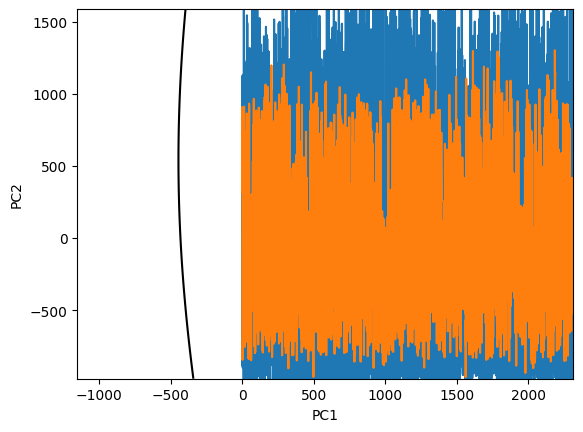

In [85]:
X_PC, Y = prep_mnist(mnist_trainset, 2)
X_test_PC, Y_test = prep_mnist(mnist_testset, 2)
preds_results = []
ged_clf = GED_Classifier(X_PC, Y)
for i in range(len(X_test_PC)):
    pred = ged_clf.classify(X_test_PC[i])
    preds_results.append((pred, Y_test[i]))

correct = 0
for pred in preds_results:
    if pred[0] == pred[1]:
        correct += 1
print(f"Accuracy for 2D GED Classifier: {round(correct/len(preds_results) * 100, 3)}%")

ged_clf.plot_decision_boundary_analytical()

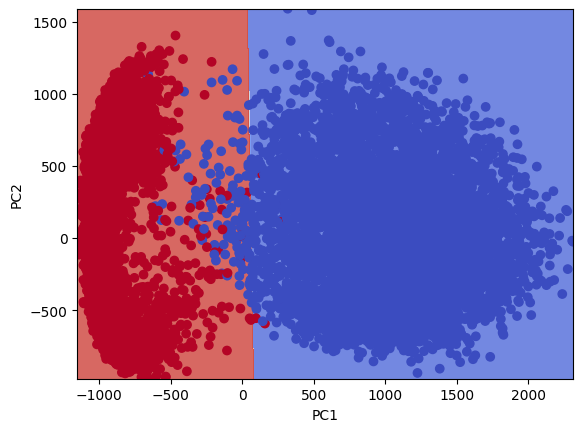

In [61]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)
X_PC, Y = prep_mnist(mnist_trainset, 2)
X_test_PC, Y_test = prep_mnist(mnist_testset, 2)

med_clf = MED_Classifier(X_PC, Y)
med_clf.plot_decision_boundary()

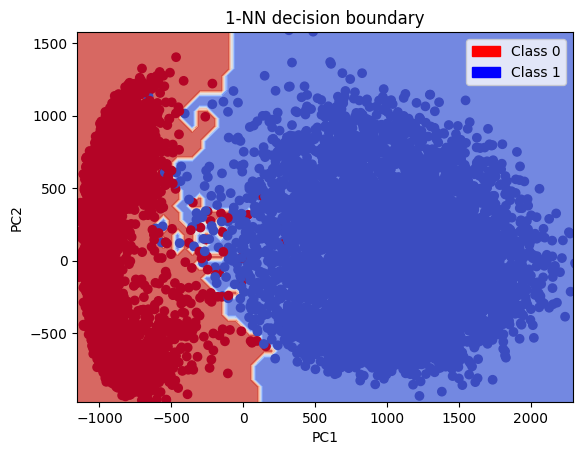

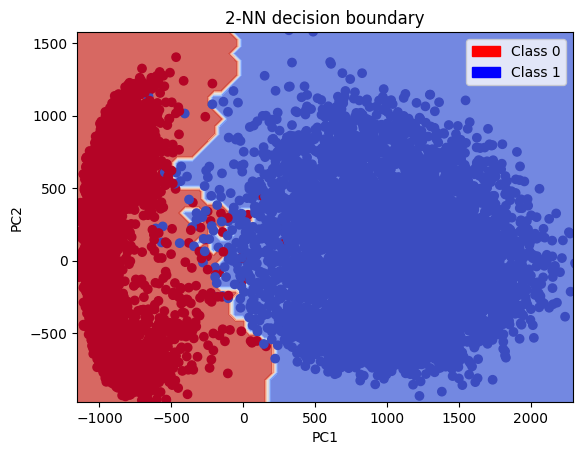

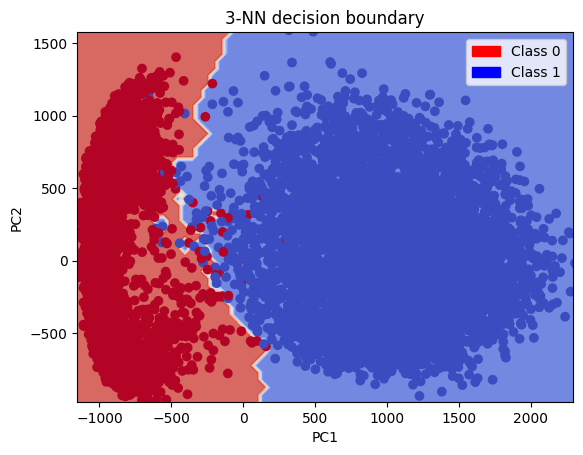

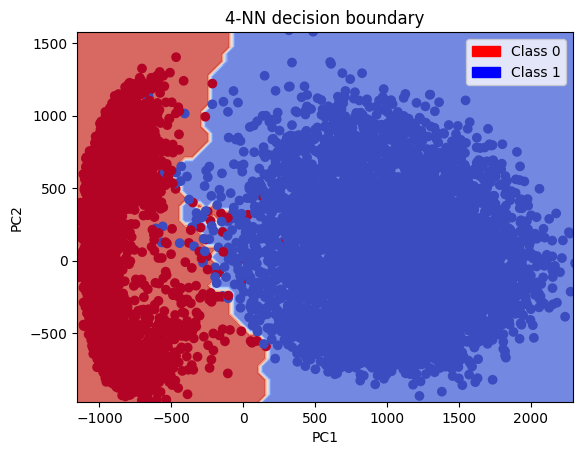

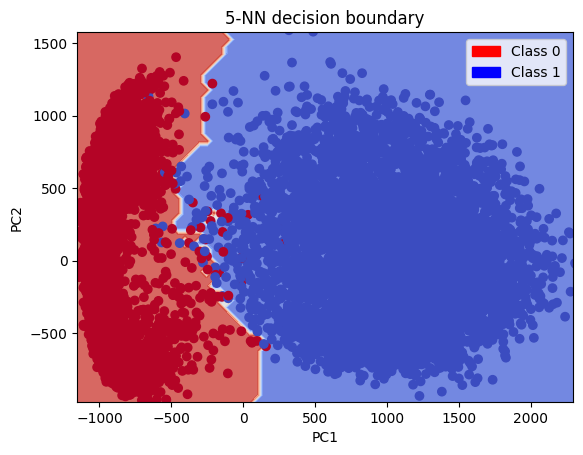

In [44]:
K_VALUES = [1, 2, 3, 4, 5]
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)

X_PC, Y = prep_mnist(mnist_trainset, 2)
X_test_PC, Y_test = prep_mnist(mnist_testset, 2)

knn = KNNClassifier(X_PC, Y)
preds_results = {}
for k_val in K_VALUES:
    knn.plot_decision_boundary(k_val)
    preds_results[k_val] = []
    for i in range(len(X_test_PC)):
        pred = knn.classify(X_test_PC[i], k_val)
        preds_results[k_val].append((pred, Y_test[i]))


In [46]:
X_PC, Y

(array([[1119.66338805,  321.49796415],
        [-883.61589229,  907.3863322 ],
        [-798.39309386, -842.90958277],
        ...,
        [-726.57401034,  652.36411163],
        [ 816.3685892 ,  679.55858522],
        [-821.88725405,  356.09634105]]),
 [0,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  1,
  1,
  0,
  1,
  1,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  0,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  0,
  0,
  0,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  0,
  0,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  0,
  1,
  0,
  0,


In [39]:
for k_val in preds_results:
    correct = 0
    for pred in preds_results[k_val]:
        if pred[0] == pred[1]:
            correct += 1
    print(f"KNN with k:{k_val} is {correct/len(preds_results[k_val])}")
    

KNN with k:1 is 0.9962174940898345
KNN with k:2 is 0.9947990543735225
KNN with k:3 is 0.9981087470449173
KNN with k:4 is 0.9971631205673759
KNN with k:5 is 0.9985815602836879


In [57]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)
X_PC, Y = prep_mnist(mnist_trainset, 20)
X_test_PC, Y_test = prep_mnist(mnist_testset, 20)

# MED classifier
med_clf = MED_Classifier(X_PC, Y)

# preds_results = []
# for i in range(len(X_test_PC)):
#     pred = med_clf.classify(X_test_PC[i])
#     preds_results.append((pred, Y_test[i]))

# correct = 0
# for pred in preds_results:
#     if pred[0] == pred[1]:
#         correct += 1

X_PC_2D, Y = prep_mnist(mnist_trainset, 2)
med_clf_2D = MED_Classifier(X_PC_2D, Y)

In [56]:
med_clf.determine_decision_boundary_analytical()

(array([[ 1.92357514e+03,  3.23408877e+01, -3.44516061e+01,
          6.46258321e+01, -2.36600160e+01, -1.53948292e+01,
          7.15544438e+01,  5.72000513e+01, -7.34020124e+00,
          3.55513135e+01,  1.01578300e+01,  6.07837164e+00,
          1.39065948e+01,  1.18260723e+01,  4.16971893e+00,
          1.24767482e+00, -6.42924894e+00, -5.16248115e+00,
          9.88546523e+00, -1.22236803e+01]]),
 array([[120210.46558703]]))

In [85]:
X_PC_2D, Y = prep_mnist(mnist_trainset, 2)
med_clf_2D = MED_Classifier(X_PC_2D, Y)
weights, bias = med_clf_2D.determine_decision_boundary_analytical()
w1 = weights[0][0]
w2 = weights[0][1]
bias = bias[0]
x = np.linspace(-1000, 100, 10)
y = bias/w2 - (w1/w2) * x

(1, 2)


In [88]:
X_PC_2D[:,0].min()

-1153.9034612718901

In [90]:
bias[0]

119671.23453452945

(-1000.0, 2000.0)

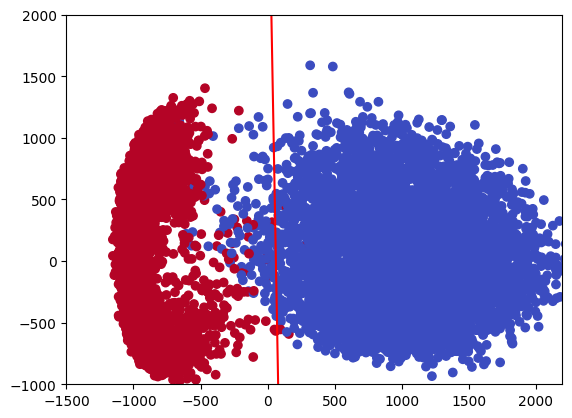

In [86]:
plt.plot(x,y, 'r')
plt.scatter(X_PC_2D[:, 0], X_PC_2D[:, 1], c=Y, cmap=plt.cm.coolwarm)
ax = plt.gca()
xlim = np.max(self.X_clf[:, 0])

xmin = 
xmax = 2200
ymin = -1000
ymax = 2000
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])

In [41]:
prototype0, prototype1 = med_clf.output_prototypes()

In [43]:
prototype0.shape[0]

20

In [44]:
prototype0 = prototype0.reshape(20,1)
prototype1 = prototype1.reshape(20,1)

In [51]:
(prototype0-prototype1).T

array([[ 1.92357514e+03,  3.23408877e+01, -3.44516060e+01,
         6.46258321e+01, -2.36600161e+01, -1.53948291e+01,
         7.15544188e+01,  5.72000751e+01, -7.34000839e+00,
         3.55514445e+01,  1.01577129e+01,  6.07755762e+00,
         1.39060865e+01,  1.18253133e+01,  4.16982429e+00,
         1.24503672e+00, -6.41338239e+00, -5.17052524e+00,
         9.86208920e+00, -1.21618156e+01]])

In [81]:
weights.sh

array([[1923.575144  ,   32.34088132]])

In [46]:
1/2* (np.matmul(prototype0.T, prototype0) - np.matmul(prototype1.T, prototype1))

array([[120210.3965457]])

In [52]:
0.5 * (np.transpose(prototype0) * prototype0 - np.transpose(prototype1) * prototype1)

array([[ 1.19637416e+05,  2.01145261e+03, -2.14272946e+03,
         4.01942581e+03, -1.47154282e+03, -9.57486676e+02,
         4.45035163e+03,  3.55757830e+03, -4.56514341e+02,
         2.21113429e+03,  6.31762440e+02,  3.77995782e+02,
         8.64893819e+02,  7.35479417e+02,  2.59343653e+02,
         7.74354863e+01, -3.98882519e+02, -3.21582592e+02,
         6.13376022e+02, -7.56408297e+02],
       [ 2.01145261e+03,  3.38183632e+01, -3.60255086e+01,
         6.75782275e+01, -2.47409108e+01, -1.60981333e+01,
         7.48233428e+01,  5.98132288e+01, -7.67533261e+00,
         3.71755925e+01,  1.06217624e+01,  6.35520748e+00,
         1.45413783e+01,  1.23655462e+01,  4.36032040e+00,
         1.30191554e+00, -6.70637421e+00, -5.40673783e+00,
         1.03126333e+01, -1.27174214e+01],
       [-2.14272946e+03, -3.60255086e+01,  3.83767026e+01,
        -7.19887003e+01,  2.63556190e+01,  1.71487731e+01,
        -7.97066659e+01, -6.37169213e+01,  8.17626089e+00,
        -3.96018464e+01, -1.1

In [1]:
# GED CLF

In [11]:
X, Y = prep_mnist(mnist_trainset, 2)
X_test_PC, Y_test = prep_mnist(mnist_testset, 2)


In [12]:
mean0 = np.mean([X[i] for i in range(len(X)) if Y[i] == 0], axis=0)
mean1 = np.mean([X[i] for i in range(len(X)) if Y[i] == 1], axis=0)

In [23]:
covariance0 = np.cov([X[i] for i in range(len(X)) if Y[i] == 0], rowvar=False)
covariance1 = np.cov([X[i] for i in range(len(X)) if Y[i] == 1], rowvar=False)
covariance0_inverse = np.linalg.inv(covariance0)
covariance1_inverse = np.linalg.inv(covariance1)

In [16]:
covariance0

array([[215286.02497588, -23351.20271356],
       [-23351.20271356, 190498.54164557]])

In [17]:
covariance1

array([[ 22049.68710374,  -8583.77628061],
       [ -8583.77628061, 380576.59239918]])

In [18]:
s1 = np.array([[3, -2], [-2, 1]])

In [22]:
np.linalg.inv(s1)

array([[-1., -2.],
       [-2., -3.]])

In [27]:
x = X_test_PC[0]
y = Y_test[0]

In [39]:
dist0 = np.sqrt(((x - mean0).T @ covariance0_inverse @ (x - mean0)))
dist1 = np.sqrt(((x - mean1).T @ covariance1_inverse @ (x - mean1)))

Accuracy for 2D GED Classifier: 99.669%


C:\ProgramData\Miniconda3\envs\ml37\lib\site-packages\ipykernel_launcher.py:208: UserWarning: The following kwargs were not used by contour: 'level'


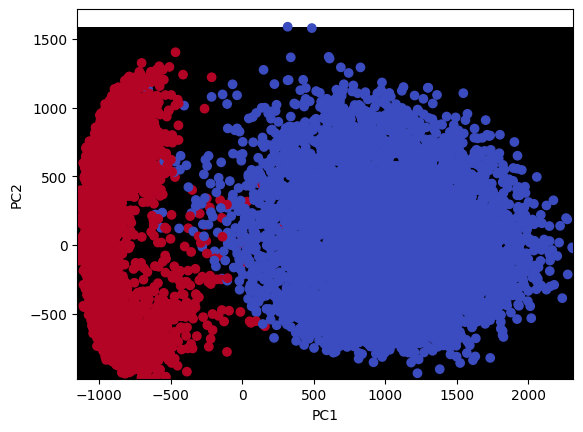

In [67]:
def decision_boundary_fct(x1, x2):
    x = np.array([x1, x2])
    return np.sqrt(((x - mean0).T @ covariance0_inverse @ (x - mean0))) - np.sqrt(((x - mean1).T @ covariance1_inverse @ (x - mean1)))